In [ ]:
"""  Brock A. et al "`Characterizing signal propagation to close the performance gap in unnormalized ResNets
<https://arxiv.org/pdf/2101.08692.pdf>`_"
"""

In [ ]:
# https://github.com/TylerYep/torchinfo/blob/e93aa4f405e86dca96f2da63cf019d4e2b4ce48c/torchinfo/torchinfo.py#L317

In [ ]:
# def SPP(net):
#     """Signal propagation plots.
    
#     Parameters
#     ----------
#     """
    
    
# # Average Channel Squared Mean:
# # np.mean(np.mean(y, axis=[0, 1, 2]) ** 2)
# # • Average Channel Variance:
# # np.mean(np.var(y, axis=[0, 1, 2]))
# # • Residual Average Channel Variance:
# # np.mean(np.var(f(x), axis=[0, 1, 2])) # y = f(x) + identity
    

# SPP for my ResNet from torch

In [4]:
from models_module.my_models import ResNet, ResBlock, ResNetLayer
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

model = ResNet(1, 10, [128], [2])

In [5]:
# old code example of filtering

# ResNet_signal_propagation = []

# def hook(self, input, output) -> None:
#     # cache signals from ResBlocks
#     ResNet_signal_propagation.append(output.detach().numpy())

# def get_all_layers(net, instances_for_hook=(), instances_with_nested_objects=[]): 
#     if not isinstance(instances_for_hook, tuple):
#         instances_for_hook = tuple(instances_for_hook)        
    
#     # add nn.Sequential, nn.ModuleList to tuple of instances_with_nested_objects
#     for instance in (nn.Sequential, nn.ModuleList):
#         if instance not in instances_with_nested_objects:
#             if not isinstance(instances_with_nested_objects, list):
#                 instances_with_nested_objects = list(instances_with_nested_objects)
#             instances_with_nested_objects.append(instance)
#     if not isinstance(instances_with_nested_objects, tuple):
#         instances_with_nested_objects = tuple(instances_with_nested_objects)
    
#     for name, layer in net._modules.items():
#         if isinstance(layer, instances_with_nested_objects):
#             # get all nested objects
#             get_all_layers(layer, instances_for_hook, instances_with_nested_objects)
#         elif isinstance(layer, instances_for_hook):
#             # hook preferable layers outputs
#             layer.register_forward_hook(hook)

# get_all_layers(net, instances_for_hook=[ResBlock], instances_with_nested_objects=[ResNetLayer])
# out = net(torch.randn(1,1,28,28))

In [6]:
def get_signal_propagation(
    module,
    signal_propagation,
):
    def hook(self, input, output):
        # Cache signals statistics per network unit
        output = output.detach().numpy()
        signal_propagation['Average Channel Squared Mean'].append(
            np.mean(np.mean(output, axis=1) ** 2)
        )
        signal_propagation['Average Channel Variance'].append(
            np.mean(np.var(output, axis=1))
        )
        signal_propagation['Instances'].append(self.__class__.__name__) #tmp
        
    # Check is it the lowest level
    submodules = [m for m in module.modules()]
    if len(submodules)==1: 
        module.register_forward_hook(hook)
    
    # Go deeper in network
    for child in module.children():
        get_signal_propagation(
            child,
            signal_propagation,
        )

def SPP_info(model, show_plots=False):
    """Signal propagation statistics.
    
    This statistics is used for signal propagation plots.
    
    """
    signal_propagation = {
        'Average Channel Squared Mean': [],
        'Average Channel Variance': [],
        'Instances': []
    }
    
    # Register forward hooks for all network units
    get_signal_propagation(model, signal_propagation)
    
    # Get hooks
    _ = model(torch.randn(3, 1, 28, 28)) # ResNet from batchflow need batch size more than 1 =(
    
    # Show signal propagation plots
    if show_plots:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        for ax, field in zip(axes, signal_propagation.keys()):
            x = range(len(signal_propagation[field]))
            ax.plot(x, signal_propagation[field])
            ax.set_title(field)
        fig.show()
    
    return signal_propagation

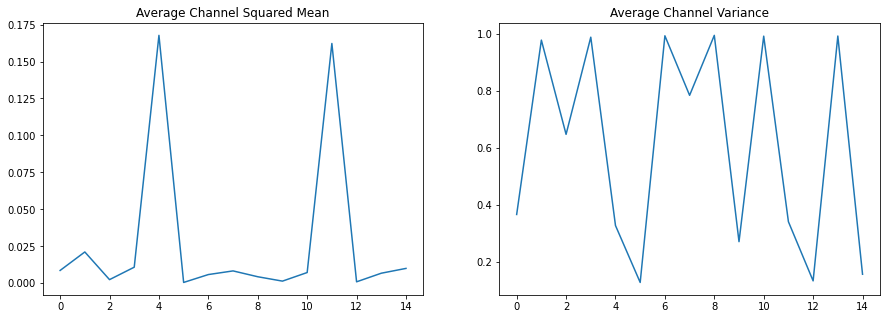

In [7]:
sp_info = SPP_info(model, show_plots=True)

In [8]:
print(len(sp_info['Average Channel Squared Mean'])) # must be 15
print(sp_info['Instances'])

15
['Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Linear']


# SPP for ResNet from batchflow

In [9]:
import sys
sys.path.append("..")

In [10]:
from batchflow.models.torch import ResNet

In [11]:
num_classes = 22
model_config = {
    'inputs/images/shape': (1, 28, 28), # can be commented
    'inputs/targets/classes': num_classes,
    'initial_block/inputs': 'images', # can be commented 
    'device': 'cpu'
}

model = ResNet(model_config).model

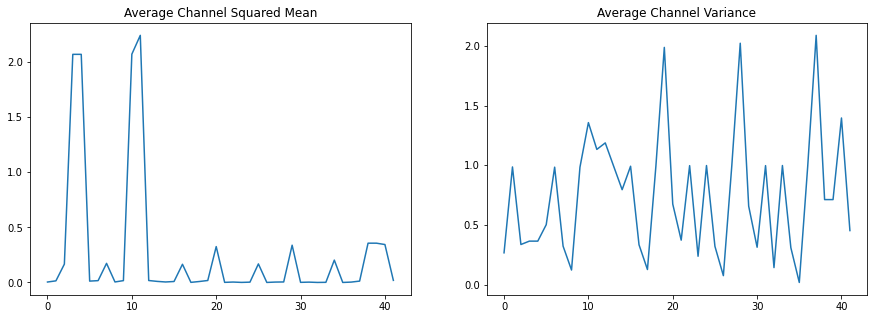

In [12]:
sp_info = SPP_info(model, show_plots=True)

In [13]:
print(len(sp_info['Average Channel Squared Mean']))
print(sp_info['Instances'])

42
['Conv2d', 'BatchNorm2d', 'ReLU', 'MaxPool2d', 'Identity', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Combine', 'ReLU', 'AdaptiveAvgPool2d', 'Dropout', 'Linear']
